# Binary classification on graph data
The objective is to perform a binary classification task on graph data. Here each graphs describe a molecule : atoms are the nodes and have a labels that can be in 50 categories.  Links between atoms are the edges and have labels in 4 categories.


## 0- Loading and vizualizing data

In [2]:
from algos.kernelrr import KernelRR


import pickle as pkl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import networkx as nx
import matplotlib.pyplot as plt


def load_data():
    with open('data/training_data.pkl', 'rb') as file:
        train_graphs = np.array(pkl.load(file),dtype=object)
    with open('data/test_data.pkl', 'rb') as file:
        test_graphs = np.array(pkl.load(file),dtype=object)
    with open('data/training_labels.pkl', 'rb') as file:
        train_labels = np.array(pkl.load(file))

    return train_graphs, test_graphs, train_labels


graphs, _ , labels = load_data()
train_graphs, test_graphs, train_labels, test_labels = train_test_split(graphs, labels, test_size=0.3)




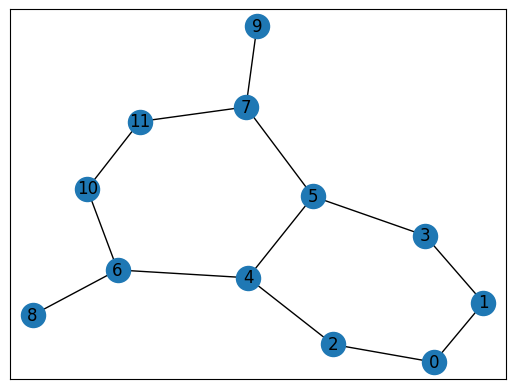

In [3]:
nx.draw_networkx(train_graphs[0])
plt.show()


In [4]:
G = train_graphs[0]
G.number_of_edges()
G.nodes[0]['labels']

[1]

## I- Predicting using a naive kernel

In [5]:
from kernels.base_kernels import Kernel, Linear

class FeatureVectorKernel(Kernel):
    """
        Abstract class of kernels based on the vectorization of the graphs
    """

    def __init__(self, vector_kernel=Linear()):
        super().__init__()
        self.vector_kernel = vector_kernel

    def features(self, X):
        """
        :param X: list of graphs
        :return: vector of features
        """
        pass

    def kernel(self, X, Y):
        return self.vector_kernel.kernel(self.features(X), self.features(Y))


class NaiveKernel(FeatureVectorKernel):
    """
        A vectorizer kernel where features are the nb of nodes and edges of the graph.
    """
    def __init__(self):
        super().__init__()

    def features(self, X):
        X_ft = np.array([(G.number_of_nodes(), G.number_of_edges()) for G in X])
        return X_ft / np.mean(X_ft, axis=0)


In [6]:

kernel = NaiveKernel().kernel

classifier = KernelRR(lmbda=1e-4, kernel=kernel)


### Compute predictions
classifier.fit(train_graphs, train_labels)
train_preds = classifier.predict(train_graphs)
test_preds = classifier.predict(test_graphs)
print("Train AUC {}".format(metrics.roc_auc_score(train_labels, train_preds)))
print("Test AUC {}".format(metrics.roc_auc_score(test_labels, test_preds)))

Train AUC 0.6975559022738973
Test AUC 0.7018787742525912


## II- Predicting using a histogram kernels

### a) Degree histrogram kernel
The Degree Histogram embedding is a vector whose ith component counts the number of nodes of degree i in the graph. The vector counts only nodes up to a maximal degree to keep dimension fixed. Implement the method **features** of the class **DegreeHistogramKernel** and run the code block following it. 


**Hint 1**: You can use the method G.degree(), which returns a dictionary whose keys are the nodes and values are their degrees.

**Hint 2**: You can use the function np.bincount to get the counts of nodes with degrees up to a maximal size. 


In [7]:
class DegreeHistogramKernel(FeatureVectorKernel):
    """
    A vector kernel applied to the degree histogram of the graphs.
    """
    def __init__(self, max_degree=1):
        super().__init__()
        self.max_degree = max_degree ### 

    def features(self, X):
        ### Takes a list of graphs X of size N and returns an array of shape Nx(MaxDeg+1). 
        
        
        return np.array([np.bincount([min(d, self.max_degree) for n, d in G.degree()], minlength=self.max_degree+1) for G in X])

In [8]:
kernel = DegreeHistogramKernel(max_degree=5).kernel

classifier = KernelRR(lmbda=1e-4, kernel=kernel)


### Compute predictions
classifier.fit(train_graphs, train_labels)
train_preds = classifier.predict(train_graphs)
test_preds = classifier.predict(test_graphs)
print("Train AUC {}".format(metrics.roc_auc_score(train_labels, train_preds)))
print("Test AUC {}".format(metrics.roc_auc_score(test_labels, test_preds)))

Train AUC 0.7306243256683699
Test AUC 0.7210401816391221


### b) Edge label histrogram kernel
The Node (resp. Label) Histogram embeddings are 50 (resp. 4) dimensional vectors whose ith component is the number of nodes (resp. edges) of label i in the graph. Implement the method **features** of the class **EdgeLabelHistogramKernel** and **NodeLabelHistogramKernel** then run the  code block following it.


**Hint 1**: You can use "G.nodes()" to get the list of nodes, and "G.edges()" to get the list of edges. 

**Hint 2**: You can use "G.nodes[n]['labels']" to access the label of node 'n' and "G.edges[i, j]['labels']" to access the label of edge (i,j).

**Hint 3**: You can use the function np.bincount to get the counts of labels, either for edges or nodes. 



In [9]:
class NodeLabelHistogramKernel(FeatureVectorKernel):
    """
    A vector kernel applied to the degree histogram of the graphs.
    """
    def __init__(self, max_nb_labels=50):
        super().__init__()
        self.max_nb_labels = max_nb_labels

    def features(self, X):
        ### Takes a list of graphs X of size N and returns an array of shape Nx(max_nb_labels). 
        X_hist = np.array([np.bincount([G.nodes[n]['labels'][0] for n in G.nodes], minlength=self.max_nb_labels) for G in X])
        return X_hist


class EdgeLabelHistogramKernel(FeatureVectorKernel):
    """
    A vector kernel applied to the edge label count of the graphs.
    """
    def __init__(self, max_nb_labels=4):
        super().__init__()
        self.max_nb_labels = max_nb_labels

    def features(self, X):
        ### Takes a list of graphs X of size N and returns an array of shape Nx(max_nb_labels). 
        return np.array([np.bincount([G.edges[i, j]['labels'][0] for (i, j) in G.edges], minlength=self.max_nb_labels) for G in X])



In [10]:
from kernels.combine_kernels import SumKernel
kernel = SumKernel([ EdgeLabelHistogramKernel(max_nb_labels=4).kernel,
                        NodeLabelHistogramKernel(max_nb_labels=50).kernel],
                       alphas=[1., 1.]).kernel

classifier = KernelRR(lmbda=1e-4, kernel=kernel)


### Compute predictions

classifier.fit(train_graphs, train_labels)
train_preds = classifier.predict(train_graphs)
test_preds = classifier.predict(test_graphs)
print("Train AUC {}".format(metrics.roc_auc_score(train_labels, train_preds)))
print("Test AUC {}".format(metrics.roc_auc_score(test_labels, test_preds)))

Train AUC 0.834347436013017
Test AUC 0.8210446149510278


## II- Predicting using a walk kernel
The WL kernel KWL(G,G′) is given by the number of co-occurrences between the two WL hash lists of graphs G and G′.

The WL hash list of G contains one hash for each rooted subtree of G (up to a certain depth). It is computed recursively by choosing a root node, computing the hash of its neighbors, concatenating them and hashing the resulting string.

Once we computed the hash lists of each graph in the dataset, the kernel matrix is obtained by computing the co-occurences of the hashes in each pair of hash lists. If done naively, this operation is very expensive: using a straightforward counting algorithm takes more than 30 minutes on the whole dataset, making it rather prohibitive.



### a) Using a naive (non-optimized) implementation of the kernel
Here, we compute predictions restrictes to N=10 training and test points since the implementation is not optimized.
Implement the method **weisfeiler_lehman_subgraph_hashes** of the class **WLKernel** then run the code block that follows. 


In [ ]:
class WLKernel(Kernel):
    """
    The Weisfeler-Lehman subraph kernel.
    """
    def __init__(self, iterations=3, optimized=False):
        super().__init__()
        self.iterations = iterations
        self.optimized = optimized

    def weisfeiler_lehman_subgraph_hashes(self, G):
        """
        Computes the WL subgraph hashes.
        :param G: A networkx graph.
        :return: A list of list of hashes (one list for each node).
        """
        # Initialize labels
        labels = {node: str(G.nodes[node]['labels']) for node in G.nodes()}

        final_hashes = {node: list() for node in G.nodes()}

        for _ in range(self.iterations):
            new_labels = {}
            for node in G.nodes():
                
                
                # Compute new features
                label_list = [str(G.edges[node,nbr]['labels']) + labels[nbr] for nbr in G.neighbors(node)]
                label = labels[node] + "".join(sorted(label_list))

                # Hash features
                hashed_label = str(hash(label))

                new_labels[node] = hashed_label
                final_hashes[node].append(hashed_label)

            labels = new_labels

        return final_hashes

    def kernel(self, X, Y):
        # Input lists of graphs X and Y of len N and M

        X_hash = [sorted(
            [subgraph_hash for vertex_hash in self.weisfeiler_lehman_subgraph_hashes(G).values() for subgraph_hash in
             vertex_hash]) for G in X]
        Y_hash = [sorted(
            [subgraph_hash for vertex_hash in self.weisfeiler_lehman_subgraph_hashes(G).values() for subgraph_hash in
             vertex_hash]) for G in Y]
        if self.optimized:
            K = optimized_coocurrence_matrix(X_hash, Y_hash)
        else:
            K = cooccurrence_matrix(X_hash, Y_hash)

        return K


In [5]:
import time
from kernels.graph_kernels import WLKernel
kernel = WLKernel(iterations=10, optimized=False).kernel

classifier = KernelRR(lmbda=1e-4, kernel=kernel)

N = 200
### Compute predictions (restricting to N=10 points since the implementation is not optimized)
start_time = time.time()
classifier.fit(train_graphs[:N], train_labels[:N])
train_preds = classifier.predict(train_graphs[:N])
test_preds = classifier.predict(test_graphs[:N])
print("Train AUC {}".format(metrics.roc_auc_score(train_labels[:N], train_preds)))
print("Test AUC {}".format(metrics.roc_auc_score(test_labels[:N], test_preds)))
print("Total time: {}".format(time.time()-start_time))





/Users/MichaelArbel/Documents/Academia/INRIA/courses/mva-kernel-methods/source_kernel_course/Formation_continue/tutorials/tutorial_2/kernels/utils.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mesh1, mesh2 = np.meshgrid(np.array(array1), np.array(array2))


Train AUC 1.0
Test AUC 0.8788156288156288
Total time: 5.6033148765563965


### b) Using an optimized implementation

It is possible to optimize the computation of co-occurences, using dictionaries to avoid redundant comparisons. 
The high-level pseudo-code is given below (where SubgraphHashList(G) computes the list of WL hashes of graph G, and Count(hash,X[i]) counts the number of occurences of hash in the list X[i]). Implementing this algorithm efficiently leads to an end-to-end training and prediction time of 1 minute on the whole dataset.

## Algorithm 1: Optimized Computation for WL Kernel

**Input:**  
- $( X, Y )$: List of graphs of length $( N, M)$.

**Output:**  
- $( K_{WL}(X, Y) )$: The WL kernel matrix of $( X )$ and $( Y )$.

---

1. Compute the list of WL hashes for each graph in $( X )$:
   $
   L_X = [\text{SubgraphHashList}(G) \text{ for } G \in X]
   $
2. Compute the list of WL hashes for each graph in $( Y )$:
   $
   L_Y = [\text{SubgraphHashList}(G') \text{ for } G' \in Y]
   $
3. Construct a dictionary mapping hashes to their occurrences in $( Y )$:
   $
   D_Y = \{ \text{hash} : [i \text{ for } i = 1, \dots, M \text{ where hash} \in Y[i]] \}
   $
4. Initialize the kernel matrix by zeros.
5. Compute the kernel matrix:
   ```
   for j = 1 to N do
       for each hash in L_X[j] do
           for each i in D_Y[hash] do
               K[j, i] = K[j, i] + min(Count(hash, X[j]), Count(hash, Y[i]))
   ```
6. Return the kernel matrix $( K )$.





After implementing the functions **create_hash_dict**, **get_hash_coocurrences** in the file **kernels/graph_kernels.py**, perform a second fit on restricted data for comparaison, by setting the option **optimized** to **True** when constructing an instance of **WLKernel**.

In [6]:
import time
from kernels.graph_kernels import WLKernel
kernel = WLKernel(iterations=10, optimized=True).kernel


classifier = KernelRR(lmbda=1e-4, kernel=kernel)

N = 200
### Compute predictions (restricting to N=10 points since the implementation is not optimized)
start_time = time.time()
classifier.fit(train_graphs[:N], train_labels[:N])
train_preds = classifier.predict(train_graphs[:N])
test_preds = classifier.predict(test_graphs[:N])
print("Train AUC {}".format(metrics.roc_auc_score(train_labels[:N], train_preds)))
print("Test AUC {}".format(metrics.roc_auc_score(test_labels[:N], test_preds)))
print("Total time: {}".format(time.time()-start_time))




Train AUC 1.0
Test AUC 0.8788156288156288
Total time: 0.785768985748291


### c) Training on full data using optimized kernel

In [9]:
import time
from kernels.graph_kernels import WLKernel
kernel = WLKernel(iterations=10, optimized=True).kernel


classifier = KernelRR(lmbda=1e-4, kernel=kernel)


### Compute predictions (restricting to N=10 points since the implementation is not optimized)
start_time = time.time()
classifier.fit(train_graphs, train_labels)
train_preds = classifier.predict(train_graphs)
test_preds = classifier.predict(test_graphs)
print("Train AUC {}".format(metrics.roc_auc_score(train_labels, train_preds)))
print("Test AUC {}".format(metrics.roc_auc_score(test_labels, test_preds)))
print("Total time: {}".format(time.time()-start_time))




Train AUC 0.9998818251831878
Test AUC 0.92239959150814
Total time: 64.11056685447693


## III- Combining multiple kernels

In [16]:
from kernels.graph_kernels import WLKernel
from kernels.feature_vector_kernels import DegreeHistogramKernel
from kernels.combine_kernels import SumKernel

kernel = SumKernel([DegreeHistogramKernel(max_degree=5).kernel,
                        WLKernel(iterations=10, optimized=True).kernel],
                       alphas=[1., 1]).kernel

classifier = KernelRR(lmbda=1e-4, kernel=kernel)


### Compute predictions
classifier.fit(train_graphs, train_labels)
train_preds = classifier.predict(train_graphs)
test_preds = classifier.predict(test_graphs)
print("Train AUC {}".format(metrics.roc_auc_score(train_labels, train_preds)))
print("Test AUC {}".format(metrics.roc_auc_score(test_labels, test_preds)))





Train AUC 0.9998824966310105
Test AUC 0.9228915707555608
